In [1]:
import os 
import cv2
import numpy as np
from tqdm import tqdm

REBUILD_DATA = False

In [2]:
class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}
    
    training_data = []
    catcount, dogcount = 0, 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount +=1
                    if label == self.DOGS:
                        self.dogcount +=1
                        
                except Exception as e:
                    pass
                    #print(str(e))
        
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print(f"Cats: {self.catcount}")
        print(f"Dogs: {self.dogcount}")
        
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats = dogsvcats.make_training_data()

In [3]:
training_data = np.load("training_data.npy", allow_pickle=True)
len(training_data)

24946

In [4]:
print(training_data[0])

[array([[111, 111, 107, ...,  56,  56,  56],
       [111, 112, 104, ...,  49,  50,  53],
       [111, 111, 107, ...,  55,  53,  54],
       ...,
       [ 77,  83,  82, ..., 207, 217, 195],
       [ 77,  81,  92, ..., 203, 177, 191],
       [ 77,  82,  80, ..., 178, 166, 181]], dtype=uint8)
 array([1., 0.])]


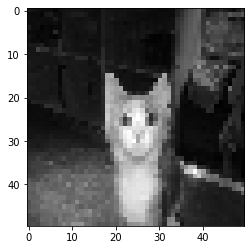

In [5]:
import matplotlib.pyplot as plt

plt.imshow(training_data[1][0], cmap="gray")

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim = 1)
    
net = Net()

In [7]:
import torch.optim as optim

optimizer = optim. Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


In [8]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

In [14]:
BATCH_SIZE = 100
EPOCHS = 5

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1, 50,50)
        batch_y = train_y[i:i+BATCH_SIZE]
        optimizer.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()

#print(loss)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [01:55<00:00,  1.95it/s]


In [15]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]
        predicted_class = torch.argmax(net_out)
    
        if predicted_class == real_class:
            correct+=1
        total+=1
    
print(f"Model accuracy: {round(correct/total, 3)}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2494/2494 [00:06<00:00, 378.72it/s]

Model accuracy: 0.781
